# Forward pass of Pytorch ConvCaps

## Learned parameters:
1. W : weights
2. beta_v
3. beta_a

**Imports, and set linewidth to 120 characters:**

In [1]:
%load_ext watermark
import torch
torch.set_printoptions(linewidth=120, threshold=20000)
from torch.autograd import Variable
from torch.distributions import Normal
import torch.nn as nn

import matplotlib.pyplot as plt
import numpy as np
import pylab as pl

import scipy.stats as scs
import seaborn as sns
import matplotlib.patches as patches
import matplotlib.path as path
%matplotlib inline

%watermark

def down_w(self, w):
    return range(w * self.stride, w * self.stride + self.K)

2018-06-01T15:25:20+02:00

CPython 3.6.5
IPython 6.4.0

compiler   : GCC 7.3.0
system     : Linux
release    : 4.15.0-22-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit


## Capsule Setup

In [2]:
"""class self():
    stride = 2
    K = 3
    C = 16 #number of outputs (number of capsules)
    beta_v = None
    beta_a = None
    W = None #weights
    transform_share = False
    coordinate_add = False
    Bkk = None
    B = 8 #number of inputs (number of capsules)
    b = None #batch size
    iteration = 3
"""
class self():
    stride = 1
    K = 1
    C = 1 #number of outputs (number of capsules)
    beta_v = None
    beta_a = None
    W = None #weights
    transform_share = False
    coordinate_add = False
    Bkk = None
    B = 14 #number of inputs (number of capsules)
    b = None #batch size
    iteration = 3
    
lambda_ = 2e-2

## Load learned parameters

**Load weight matrix W (4x4):**

In [3]:
self.W = torch.load('weights_kernel2_14->1caps.pt')
#W = W.view(B,K,K,C,4,4)
print (self.W.shape)
print (self.W[0,0,0,0,:,:])

torch.Size([14, 1, 1, 1, 4, 4])
tensor([[-0.9127,  1.3840, -1.2734,  0.1582],
        [ 0.0125, -0.6621, -0.1002,  1.1276],
        [-1.0142,  0.8510,  0.9095, -0.8480],
        [ 1.7157,  0.7491, -0.7825, -0.0374]], device='cuda:0')


**Load beta v and a:**

In [4]:
self.beta_v = torch.load('beta_v_kernel2_14->1caps.pt')
self.beta_a = torch.load('beta_a_kernel2_14->1caps.pt')
#beta_v = nn.Parameter(torch.randn(1, Cww, 1)).cuda()
#beta_a = nn.Parameter(torch.randn(1, Cww)).cuda()

## Load capsule input (x)

In [5]:
poses = torch.load('poses_kernel2_14->1caps.pt')
#x = torch.tensor(torch.arange(b*B*4*4*width_in*width_in)).view(b, 4*4*B, width_in, width_in)
print (poses.shape)
print(poses[0,0,:,:])

torch.Size([1, 224, 2, 2])
tensor([[-0.5450, -0.5450],
        [-0.5450, -0.5450]], device='cuda:0')


## Load capsule input (activations)

In [6]:
activations = torch.load('activations_kernel2_14->1caps.pt')     ; print ("activations =", activations.shape)

activations = torch.Size([1, 14, 2, 2])


## Calculate output width

In [7]:
width_in = poses.size(2)
w = int((width_in - self.K) / self.stride + 1) if self.K else 1  ; print ("w =", w)
self.Cww = w * w * self.C                                        ; print ("Cww =", self.Cww)
self.b = poses.size(0)                                           ; print ("batch_size =", self.b)

w = 2
Cww = 4
batch_size = 1


In [8]:
if self.beta_v is None:
    self.beta_v = nn.Parameter(torch.randn(1, self.Cww, 1)).cuda()
    self.beta_a = nn.Parameter(torch.randn(1, self.Cww)).cuda()

if self.transform_share:
    if self.K == 0:
        self.K = width_in  # class Capsules' kernel = width_in
    W = self.W.view(self.B, 1, 1, self.C, 4, 4).expand(self.B, self.K, self.K, self.C, 4, 4).contiguous()
else:
    W = self.W                                                   ; print ("W =", W.shape) # B,K,K,C,4,4

self.Bkk = self.K * self.K * self.B                              ; print ("Bkk =", self.Bkk)

W = torch.Size([14, 1, 1, 1, 4, 4])
Bkk = 14


## Pose matrix

In [9]:
pose = poses.contiguous()  # b,16*32,12,12
pose = pose.view(self.b, 16, self.B, width_in, width_in).permute(0, 2, 3, 4, 1).contiguous()  # b,B,12,12,16

**Print pose as 12x12 input:**

In [10]:
print (pose.shape)
print (pose[0,0,:,:,0])

torch.Size([1, 14, 2, 2, 16])
tensor([[-0.5450, -0.5450],
        [-0.5450, -0.5450]], device='cuda:0')


**Store every capsule i's poses in each capsule c's receptive field:**

First show some temporary data

In [11]:
tmp = torch.stack([pose[:, :, self.stride*i:self.stride*i+self.K, self.stride*j:self.stride*j+self.K, :]
                   for i in range(w) for j in range(w)])
print (tmp.shape)
print (tmp[0,0,0,:,:,0])
print (tmp[1,0,0,:,:,0])

torch.Size([4, 1, 14, 1, 1, 16])
tensor([[-0.5450]], device='cuda:0')
tensor([[-0.5450]], device='cuda:0')


In [12]:
tmp = torch.stack([pose[:, :, self.stride*i:self.stride*i+self.K, self.stride*j:self.stride*j+self.K, :]
                   for i in range(w) for j in range(w)], dim=-1)
print (tmp.shape)
print (tmp[0,0,:,:,0,0])
print (tmp[0,0,:,:,0,1])

torch.Size([1, 14, 1, 1, 16, 4])
tensor([[-0.5450]], device='cuda:0')
tensor([[-0.5450]], device='cuda:0')


**Create outputs from convolutions:**

In [13]:
poses = torch.stack([pose[:, :, self.stride * i:self.stride * i + self.K,
                     self.stride * j:self.stride * j + self.K, :] for i in range(w) for j in range(w)],
                    dim=-1)  # b,B,K,K,w*w,16
poses = poses.view(self.b, self.B, self.K, self.K, 1, w, w, 4, 4)  # b,B,K,K,1,w,w,4,4
        
print ("poses =", poses.shape)

poses = torch.Size([1, 14, 1, 1, 1, 2, 2, 4, 4])


**5x5 matrix:**

In [14]:
print (poses.shape)
print (poses[0,0,0,0,0,0,0,:,:])

torch.Size([1, 14, 1, 1, 1, 2, 2, 4, 4])
tensor([[-0.5450, -0.5450, -0.5450, -0.5450],
        [ 0.0993,  0.0993,  0.0993,  0.0993],
        [ 0.2873,  0.2873,  0.2873,  0.2873],
        [-0.2228, -0.2228, -0.2228, -0.2228]], device='cuda:0')


**W_hat:**

In [15]:
W_hat = W[None, :, :, :, :, None, None, :, :]  # 1,B,K,K,C,1,1,4,4

**Calculate votes:**

In [16]:
votes = W_hat @ poses  # b,B,K,K,C,w,w,4,4

In [17]:
print ("Votes =", votes.shape)
print (votes[0,0,0,0,0,0,0,:,:])

Votes = torch.Size([1, 14, 1, 1, 1, 2, 2, 4, 4])
tensor([[ 0.2338,  0.2338,  0.2338,  0.2338],
        [-0.3526, -0.3526, -0.3526, -0.3526],
        [ 1.0875,  1.0875,  1.0875,  1.0875],
        [-1.0772, -1.0772, -1.0772, -1.0772]], device='cuda:0')


## Activation Matrix

In [18]:
print (down_w(self, w=0))
print (down_w(self, w=1))
print (down_w(self, w=2))

range(0, 1)
range(1, 2)
range(2, 3)


**Stack activations to match output size:**

In [19]:
activations_ = [activations[:, :, down_w(self, x), :][:, :, :, down_w(self, y)]
                for x in range(w) for y in range(w)]

print (len(activations_))
print (activations_[0].shape)

4
torch.Size([1, 14, 1, 1])


In [20]:
activation = torch.stack(activations_, dim=4).view(self.b, self.Bkk, 1, -1)
print (activation.shape)
print (activation[0,0,:,:])

torch.Size([1, 14, 1, 4])
tensor([[ 0.4660,  0.4660,  0.4660,  0.4660]], device='cuda:0')


**Again stack activations to match number of capsules:**

In [21]:
activation = activation.repeat(1, 1, self.C, 1)
print (activation.shape)
activation = activation.view(self.b, self.Bkk, self.Cww)
print (activation.shape)

torch.Size([1, 14, 1, 4])
torch.Size([1, 14, 4])


**Format votes:**

In [22]:
votes = votes.view(self.b, self.Bkk, self.Cww, 16)
print ("Votes =", votes.shape)

votes[0,:,0,0] = torch.tensor([-6,-5.9,-1,-1.02,-1.04,-1.06,-1.08,-1.1,-1.12,-1.14,-1.16,-1.18,2,2.1])

print (votes[0,:,0,0])

Votes = torch.Size([1, 14, 4, 16])
tensor([-6.0000, -5.9000, -1.0000, -1.0200, -1.0400, -1.0600, -1.0800, -1.1000, -1.1200, -1.1400, -1.1600,
        -1.1800,  2.0000,  2.1000], device='cuda:0')


# EM routing

First we need a function to show graphics:

In [23]:
def graphics(V, mu, sigma_square, R):
    data = [V[i].item() for i in range(len(V))]
        
    new_mus = mu.item()
    new_sigs = sigma_square.item()

    dataX = np.array([R[i].item()*4 for i in range(len(R))])
    
    mind = np.min(data)
    maxd = np.max(data)

    xx = np.linspace(mind-(maxd-mind), maxd+(maxd-mind), 100)
    yy = scs.multivariate_normal.pdf(xx, mean=new_mus, cov=new_sigs)

    colors = sns.color_palette('Dark2', 3)
    fig, ax = plt.subplots(figsize=(9, 7))
    ax.set_ylim(-0.001, np.max(yy))
    ax.plot(xx, yy, color=colors[1])
    ax.axvline(new_mus, ymin=0., color=colors[1])
    ax.fill_between(xx, 0, yy, alpha=0.5, color=colors[1])
    lo, hi = ax.get_ylim()
    
    ax.annotate(f'$\mu_1$: {new_mus:3.2f}',
                fontsize=12, fontweight='demi',
                xy=(new_mus, (hi-lo) / 2), 
                xycoords='data', xytext=((maxd+(maxd-mind))*0.75, (hi-lo) / 2),
                arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0.2",shrink=0.05))
    
    ax.fill_between(xx, 0, yy, alpha=0.5, color=colors[2])

    scale = (np.max(yy) / np.max(dataX)) / 2
    dataX = scale * dataX
    
    dot_kwds = dict(markerfacecolor='white', markeredgecolor='black', markeredgewidth=1, markersize=10)
    ax.plot(data, dataX, 'o', **dot_kwds)
    #ax.plot(data, len(data)*[0], 'o', **dot_kwds)
    plt.show()

def histogram(a):
    fig, ax = plt.subplots()

    # histogram our data with numpy

    data = [a[i].item() for i in range(a.size(0))]
    n, bins = np.histogram(data, 50)

    # get the corners of the rectangles for the histogram
    left = np.array(bins[:-1])
    right = np.array(bins[1:])
    bottom = np.zeros(len(left))
    top = bottom + n


    # we need a (numrects x numsides x 2) numpy array for the path helper
    # function to build a compound path
    XY = np.array([[left, left, right, right], [bottom, top, top, bottom]]).T

    # get the Path object
    barpath = path.Path.make_compound_path_from_polys(XY)

    # make a patch out of it
    patch = patches.PathPatch(barpath)
    ax.add_patch(patch)

    # update the view limits
    ax.set_xlim(left[0], right[-1])
    ax.set_ylim(bottom.min(), top.max())

    plt.show()

*The pose matrix and the activation of the output capsules are computed iteratively using the EM routing. The EM method fits datapoints into a a mixture of Gaussian models with alternative calls between an E-step and an M-step.*

3 Initialize the assignment probability **$r_{ij}$** to be uniformly distributed. i.e. we start with the children capsules equally related with any parents

12 M-step to compute an updated Gaussian model (μ, σ) and the parent activation **$a_{j}$** from a, V and current **$r_{ij}$**

18 Plot mu,sigma^2 distribution, and plot votes (x-axis) and their routing strength (y-axis).

20 E-step to recompute the assignment probabilities **$r_{ij}$** based on the new Gaussian model and the new **$a_{j}$**.

31 Finally, plot histogram of activation a.

In [44]:
def EM_routing(self, lambda_, a_, V):
    # routing coefficient
    R = Variable(torch.ones([self.b, self.Bkk, self.Cww]), requires_grad=False).cuda() / self.Cww

    print ("Activation:",a_.shape)
    print ("Votes     :",V.shape)
    print ("R         :",R.shape)
    
    for i in range(self.iteration):
        print ()
        print ("iteration",i,":")
        # M-step
        R = (R * a_)[..., None]
        sum_R = R.sum(1)
        mu = ((R * V).sum(1) / sum_R)[:, None, :, :]; print ("mu:",mu[0,:,0,0].item(),mu.shape)
        sigma_square = (R * (V - mu) ** 2).sum(1) / sum_R; print ("sigma^2:",sigma_square[0,0,0].item(),sigma_square.shape)

        print("V     =",V.shape)
        print("mu    =",mu.shape)
        print("sig²2 =",sigma_square.shape)
        print("R     =",R.shape)
        graphics(V[0,:,0,0], mu[0,:,0,0], sigma_square[0,0,0], R[0,:,0,0])

        # E-step
        if i != self.iteration - 1:
            mu, sigma_square, V_, a__ = mu.data, sigma_square.data, V.data, a_.data
            normal = Normal(mu, sigma_square[:, None, :, :] ** (1 / 2))
            p = torch.exp(normal.log_prob(V_))
            print("V=",V_[0,:,0,0])
            print("p=",p[0,:,0,0])
            print("p=",p[0,0,0,:])
            print("p.shape=",p.shape)
            print("p.sum.shape=",p.sum(-1).shape)
            print("p.sum000=",p.sum(-1)[0,0,0])
            ap = a__ * p.sum(-1)
            print("ap.shape=",ap.shape)
            R = Variable(ap / torch.sum(ap, -1)[..., None], requires_grad=False)
        else:
            const = (self.beta_v.expand_as(sigma_square) + torch.log(sigma_square)) * sum_R
            a = torch.sigmoid(lambda_ * (self.beta_a.repeat(self.b, 1) - const.sum(2)))

    print ()
    print ("a:", a.shape)
    histogram(a[0,:])
            
    return a, mu


Activation: torch.Size([1, 14, 4])
Votes     : torch.Size([1, 14, 4, 16])
R         : torch.Size([1, 14, 4])

iteration 0 :
mu: -1.3906699419021606 torch.Size([1, 1, 4, 16])
sigma^2: 4.760664463043213 torch.Size([1, 4, 16])
V     = torch.Size([1, 14, 4, 16])
mu    = torch.Size([1, 1, 4, 16])
sig²2 = torch.Size([1, 4, 16])
R     = torch.Size([1, 14, 4, 1])


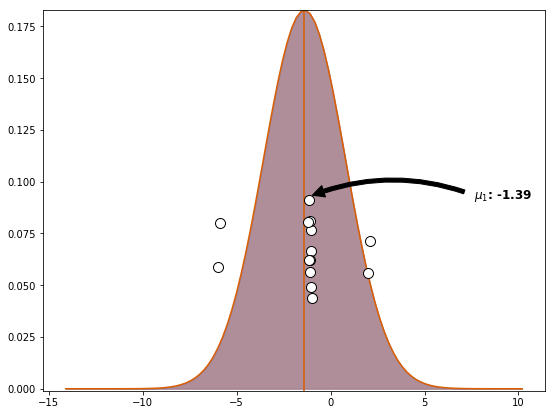

V= tensor([-6.0000, -5.9000, -1.0000, -1.0200, -1.0400, -1.0600, -1.0800, -1.1000, -1.1200, -1.1400, -1.1600,
        -1.1800,  2.0000,  2.1000], device='cuda:0')
p= tensor([ 0.0196,  0.0216,  0.1799,  0.1802,  0.1805,  0.1808,  0.1810,  0.1812,  0.1814,  0.1816,  0.1818,
         0.1820,  0.0547,  0.0509], device='cuda:0')
p= tensor([ 0.0196,  0.2436,  0.2436,  0.2436,  0.3129,  0.3129,  0.3129,  0.3129,  0.2934,  0.2934,  0.2934,
         0.2934,  0.2367,  0.2367,  0.2367,  0.2367], device='cuda:0')
p.shape= torch.Size([1, 14, 4, 16])
p.sum.shape= torch.Size([1, 14, 4])
p.sum000= tensor(4.1223, device='cuda:0')
ap.shape= torch.Size([1, 14, 4])

iteration 1 :
mu: -1.4185725450515747 torch.Size([1, 1, 4, 16])
sigma^2: 4.592257022857666 torch.Size([1, 4, 16])
V     = torch.Size([1, 14, 4, 16])
mu    = torch.Size([1, 1, 4, 16])
sig²2 = torch.Size([1, 4, 16])
R     = torch.Size([1, 14, 4, 1])


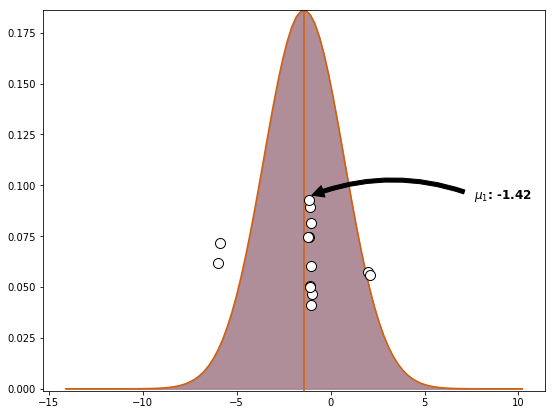

V= tensor([-6.0000, -5.9000, -1.0000, -1.0200, -1.0400, -1.0600, -1.0800, -1.1000, -1.1200, -1.1400, -1.1600,
        -1.1800,  2.0000,  2.1000], device='cuda:0')
p= tensor([ 0.0189,  0.0209,  0.1826,  0.1830,  0.1833,  0.1836,  0.1839,  0.1841,  0.1844,  0.1846,  0.1848,
         0.1850,  0.0522,  0.0484], device='cuda:0')
p= tensor([ 0.0189,  0.2467,  0.2467,  0.2467,  0.3249,  0.3249,  0.3249,  0.3249,  0.2993,  0.2993,  0.2993,
         0.2993,  0.2517,  0.2517,  0.2517,  0.2517], device='cuda:0')
p.shape= torch.Size([1, 14, 4, 16])
p.sum.shape= torch.Size([1, 14, 4])
p.sum000= tensor(4.2626, device='cuda:0')
ap.shape= torch.Size([1, 14, 4])

iteration 2 :
mu: -1.4312485456466675 torch.Size([1, 1, 4, 16])
sigma^2: 4.524186611175537 torch.Size([1, 4, 16])
V     = torch.Size([1, 14, 4, 16])
mu    = torch.Size([1, 1, 4, 16])
sig²2 = torch.Size([1, 4, 16])
R     = torch.Size([1, 14, 4, 1])


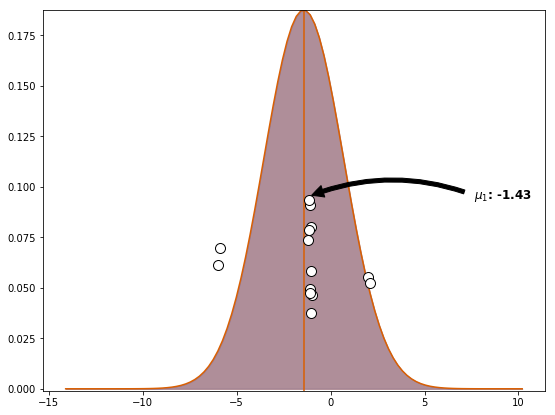


a: torch.Size([1, 4])


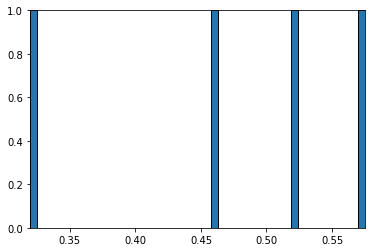

In [45]:
activations, poses = EM_routing(self, lambda_, activation, votes)

$$\mu^h_j = \dfrac{\sum_i r_{ij} V^h_{ij}}{\sum_i r_{ij}}$$
$$(\sigma^h_j)^2 = \dfrac{\sum_i r_{ij} (V^h_{ij} - mu^h_j)^2}{\sum_i r_{ij}}$$
$$cost_h = (\beta_u + log \sigma^h_j) * \sum_i r_{ij}$$
$$a_j = logistic(\lambda * (\beta_a - \sum_h cost_h))$$